In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, accuracy_score, precision_score, mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

import sys
sys.path.append('../')
from src.models.agg_catboost import agg_catboost

%matplotlib inline
# plt.style.use('dark_background')
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

In [2]:
blocks = pd.read_csv('../data/processed/blocks_sev_score.csv', index_col=0)
intersections = pd.read_csv('../data/processed/intersections_sev_score.csv', index_col=0)
circles = pd.read_csv('../data/processed/circles_sev_score.csv', index_col=0)
crosswalks = pd.read_csv('../data/processed/crosswalks_sev_score.csv', index_col=0)

# Blocks

In [34]:
blocks.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'year', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [37]:
# drop columns that would need to be collected at scene of collision
b_to_drop = ['count', 'year', 'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles', 'trandescript',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible']

blocks.drop(columns=b_to_drop, inplace=True)

In [160]:
distinct_blocks = blocks.groupby(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway', 'tranclass',
       'surfacetype_1', 'nationhwysys', 'streettype','slope_pct', 'parkboulevard']).sum().reset_index()

In [161]:
distinct_blocks.loc[7430, 'segdir'] = 'E'

In [162]:
distinct_blocks.head()

,location,artdescript,speedlimit,segdir,oneway,tranclass,surfacetype_1,nationhwysys,streettype,slope_pct,parkboulevard,sev_score
0,10TH AVE BETWEEN E ALDER ST AND E TERRACE ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000062
1,10TH AVE BETWEEN E FIR ST AND DEAD END 1,Not Designated,20.0,N,N,0,PCC,N,Urban Village Neighborhood Access,4.0,N,0.000000
2,10TH AVE BETWEEN E MADISON ST AND E SENECA ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000084
3,10TH AVE BETWEEN E PIKE ST AND E PINE ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,2.0,N,0.000369
4,10TH AVE BETWEEN E SENECA ST AND E UNION ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000026


In [163]:
distinct_blocks['parkboulevard'] = distinct_blocks['parkboulevard'].map({'Y':1, 'N':0})
distinct_blocks['nationhwysys'] = distinct_blocks['nationhwysys'].map({'Y':1, 'N':0})
distinct_blocks['oneway'] = distinct_blocks['oneway'].map({'Y':1, 'N':0})

#### Target and Features

In [164]:
y = distinct_blocks.pop('sev_score')

In [114]:
X = distinct_blocks.drop(columns='location').copy()

In [87]:
X.head()

,artdescript,speedlimit,segdir,oneway,tranclass,surfacetype_1,nationhwysys,streettype,slope_pct,parkboulevard
0,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0
1,Not Designated,20.0,N,0,0,PCC,0,Urban Village Neighborhood Access,4.0,0
2,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0
3,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,2.0,0
4,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0


#### Catboost Blocks

In [224]:
cat_feats = ['artdescript', 'segdir', 'surfacetype_1']

clf = agg_catboost(X, y, cat_feats)

In [225]:
clf.train_model()

'Training on 5 k-folds complete'

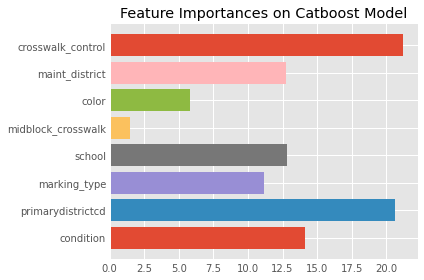

In [25]:
clf.plot_feature_importances()
# plt.savefig('../reports/figures/blocks_cat_featimport.png')

#### Random Forest Blocks

In [117]:
# X = pd.get_dummies(X, drop_first=True)

In [26]:
art_descript_dict = {'Not Designated':0, 'Minor Arterial':2, 'Principal Arterial':3,
       'Collector Arterial':1, 'Interstate/Freeway':4, 'State Route/Freeway':4,
       'County Arterial':4}

distinct_blocks['artdescript'] = distinct_blocks['artdescript'].map(art_descript_dict)

NameError: name 'distinct_blocks' is not defined

In [167]:
surfacetype_dict = {'PCC':1, 'AC/PCC':1, 'ST':2, 'AC':0, 'AC/AC':0, 'GRAVEL':3}
distinct_blocks['surfacetype_1'] = distinct_blocks['surfacetype_1'].map(surfacetype_dict)

In [ ]:
# streettype_dict = {'Neighborhood Yield Street', 'Urban Village Neighborhood Access',
#        'Neighborhood Corridor', 'Urban Center Connector',
#        'Urban Village Neighborhood', 'Urban Village Main',
#        'Minor Industrial Access', 'Industrial Access', 'Downtown',
#        'Downtown Neighborhood', 'Downtown Neighborhood Access', 'Alley'}

In [168]:
segdir_dict = {'E':1, 'N':0, 'S':2, 'W':3, 'NE':1, 'NW':0, 'SE':2, 'SW':3}

distinct_blocks['segdir'] = distinct_blocks['segdir'].map(segdir_dict)

In [231]:
X = distinct_blocks.drop(columns=['location', 'streettype', 'tranclass']).copy()

In [232]:
y = (y > 0).astype(int)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [234]:
X

,artdescript,speedlimit,segdir,oneway,surfacetype_1,nationhwysys,slope_pct,parkboulevard
0,0,20.0,0,0,0,0,1.0,0
1,0,20.0,0,0,1,0,4.0,0
2,0,20.0,0,0,0,0,1.0,0
3,0,20.0,0,0,0,0,2.0,0
4,0,20.0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...
23614,2,25.0,1,0,1,0,2.0,0
23615,0,20.0,2,0,1,0,4.0,0
23616,0,20.0,2,0,1,0,3.0,0
23617,0,20.0,2,0,2,0,7.0,0


In [271]:
rf_kfold = RandomForestClassifier(n_estimators=400)

mses = []
accuracies = []
precisions = []
recalls = []
    
fprs = []
tprs = []
thresholds = []

feat_importances = []

kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rf_kfold.fit(X_train, y_train)
            pred = rf_kfold.predict(X_test)
            proba = rf_kfold.predict_proba(X_test)

            feat_importances.append(rf_kfold.feature_importances_)
            
            #mean squared error of the y_test values and the predicted
            err = mean_squared_error(y_test, pred)
            mses.append(err)

            #accuracy scores
            accu = accuracy_score(y_test, pred)
            accuracies.append(accu)

            #precision scores
            precise = precision_score(y_test, pred)
            precisions.append(precise)

            #recall scores
            recall = recall_score(y_test, pred)
            recalls.append(recall)
            
            roc_auc = roc_auc_score(y_test, pred)

            fpr_val, tpr_val, thresholds_val = roc_curve(y_test, proba[:, 1])

            fprs.append(fpr_val)
            tprs.append(tpr_val)
            thresholds.append(thresholds_val)

In [276]:
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
print(f'     Average MSE Score       : {np.mean(mses):2.5f}')
print(f'     ROC AUC Score           : {roc_auc:2.2f}')

     Average Accuracy Score  : 0.73077
     Average Precision Score : 0.75071
     Average Recall Score    : 0.94093
     Average MSE Score       : 0.26923
     ROC AUC Score           : 0.56


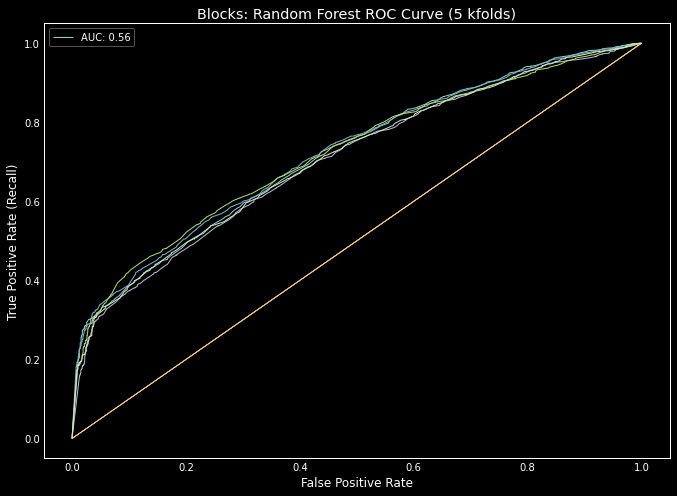

In [298]:
fig, ax = plt.subplots(figsize=(10,8))

for i in range(len(fprs)):
    ax.plot(fprs[i], tprs[i], linewidth=1)
    ax.plot([0,1], [0,1], linewidth=0.7)
    ax.grid(False)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title('Blocks: Random Forest ROC Curve (5 kfolds)')
ax.legend([f'AUC: {roc_auc:2.2f}'])
    
plt.savefig('../reports/figures/blocks_rf_kfolds.png')

In [386]:
# # Plot the feature importance
# feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf_kfold.feature_importances_},
#                            index=X.columns)
# feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
# feat_scores.plot(kind='barh', figsize=(15,8))
# plt.legend(loc='lower right')
# plt.title('Blocks: Random Forest Feature Importance');

# plt.savefig('../reports/figures/blocks_rf_featimportance.png')

# Intersections

# Circles

In [3]:
circles.head()

,intkey,shape_lat,shape_lng,unitdesc,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,inattentionind_y,year,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
0,31889,47.566489,-122.380088,38TH AVE SW AND SW DAKOTA ST,DISTRICT1,2000,1,0,0,CRC,GOOD,0.0,2006.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000337
1,31889,47.566489,-122.380088,38TH AVE SW AND SW DAKOTA ST,DISTRICT1,2000,1,0,0,CRC,GOOD,0.0,2017.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.001011
4,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,0.0,2005.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.001011
5,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,0.0,2006.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000337
6,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,0.0,2011.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.001348


In [4]:
circles.columns

Index(['intkey', 'shape_lat', 'shape_lng', 'unitdesc', 'primarydistrictcd',
       'installed', 'landscaping', 'survey_monument', 'trcsize', 'trcshape',
       'condition', 'inattentionind_y', 'year', 'count', 'total fatalities',
       'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [5]:
distinct_crc = circles.groupby(['intkey', 'shape_lat', 'shape_lng', 'unitdesc', 'primarydistrictcd',
       'installed', 'landscaping', 'survey_monument', 'trcsize', 'trcshape',
       'condition', 'inattentionind_y']).sum().drop(columns='year').reset_index()

In [6]:
distinct_crc['collisions'] = (distinct_crc['sev_score'] > 0).astype(int)

In [7]:
distinct_crc['primarydistrictcd'] = distinct_crc['primarydistrictcd'].apply(lambda x: int(x[-1]))

In [8]:
distinct_crc['condition'].value_counts().index

Index(['GOOD', 'FAIR', 'POOR'], dtype='object')

In [9]:
to_drop = ['intkey', 'shape_lat', 'shape_lng', 'unitdesc', 'count', 'total fatalities',
       'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score']
distinct_crc.drop(columns=to_drop, inplace=True)

In [10]:
distinct_crc.head()

,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,inattentionind_y,collisions
0,6,1970,1,1,25,OVAL,GOOD,0.0,1
1,6,1993,1,0,0,CRC,GOOD,1.0,1
2,6,2002,1,0,0,CRC,GOOD,0.0,0
3,6,2002,1,0,0,CRC,GOOD,0.0,0
4,6,1996,1,0,0,CRC,GOOD,0.0,0


In [11]:
distinct_crc = pd.get_dummies(distinct_crc)

In [12]:
distinct_crc.drop(columns=['trcshape_OTHER', 'condition_FAIR'], inplace=True)

## Training data

In [13]:
y = distinct_crc.pop('collisions')

In [14]:
X = distinct_crc.drop(columns=['installed', 'inattentionind_y','primarydistrictcd', 'survey_monument', 'trcsize']).copy()

In [15]:
rf_kfold = RandomForestClassifier(n_estimators=400)

mses = []
accuracies = []
precisions = []
recalls = []
    
fprs = []
tprs = []
thresholds = []

feat_importances = []

kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rf_kfold.fit(X_train, y_train)
            pred = rf_kfold.predict(X_test)
            proba = rf_kfold.predict_proba(X_test)

            feat_importances.append(rf_kfold.feature_importances_)
            
            #mean squared error of the y_test values and the predicted
            err = mean_squared_error(y_test, pred)
            mses.append(err)

            #accuracy scores
            accu = accuracy_score(y_test, pred)
            accuracies.append(accu)

            #precision scores
            precise = precision_score(y_test, pred)
            precisions.append(precise)

            #recall scores
            recall = recall_score(y_test, pred)
            recalls.append(recall)
            
            roc_auc = roc_auc_score(y_test, pred)

            fpr_val, tpr_val, thresholds_val = roc_curve(y_test, proba[:, 1])

            fprs.append(fpr_val)
            tprs.append(tpr_val)
            thresholds.append(thresholds_val)

In [16]:
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
print(f'     Average MSE Score       : {np.mean(mses):2.5f}')
print(f'     ROC AUC Score           : {roc_auc:2.2f}')

     Average Accuracy Score  : 0.60420
     Average Precision Score : 0.60642
     Average Recall Score    : 0.98720
     Average MSE Score       : 0.39580
     ROC AUC Score           : 0.50


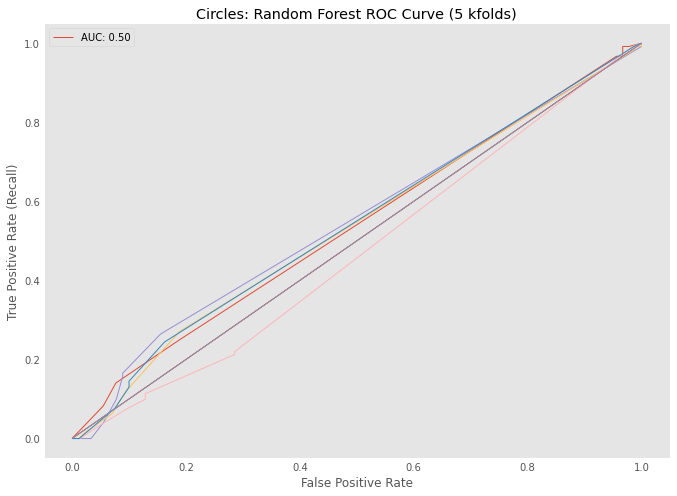

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

for i in range(len(fprs)):
    ax.plot(fprs[i], tprs[i], linewidth=1)
    ax.plot([0,1], [0,1], linewidth=0.7)
    ax.grid(False)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title('Circles: Random Forest ROC Curve (5 kfolds)')
ax.legend([f'AUC: {roc_auc:2.2f}'])
    
# plt.savefig('../reports/figures/circles_rf_kfolds.png')

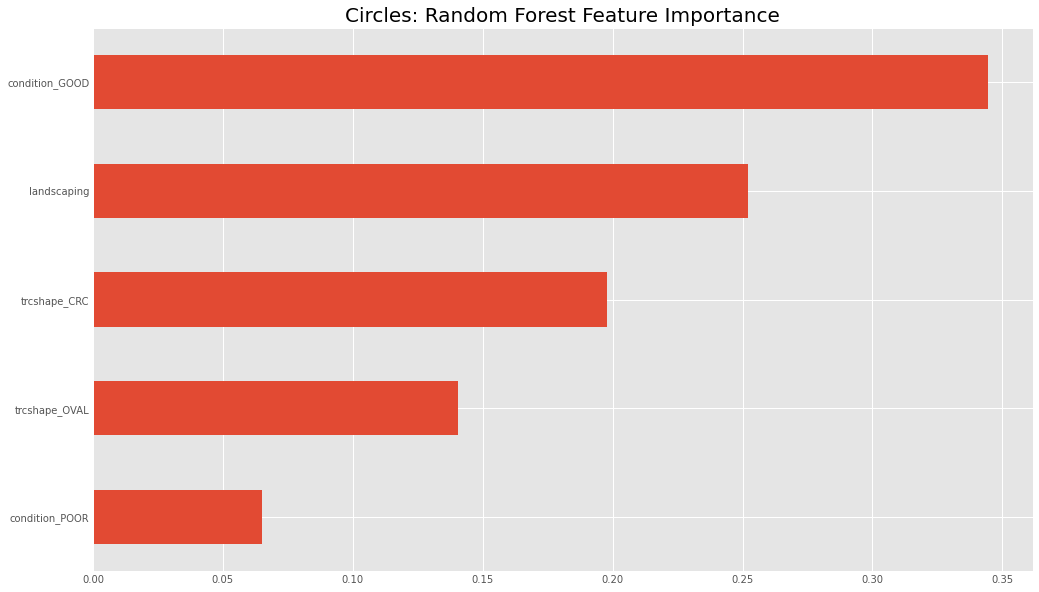

In [19]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(15,10))

feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf_kfold.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
# ax = barh(feat_scores.index, feat_scores['Fraction of Samples Affected'])
ax = feat_scores['Fraction of Samples Affected'].plot(kind='barh')
ax.set_title('Circles: Random Forest Feature Importance', fontsize=20);

plt.savefig('../reports/figures/circles_rf_featimportance.png')

# Crosswalks

In [3]:
crosswalks.columns

Index(['crosswalkkey', 'unitdesc', 'condition', 'primarydistrictcd',
       'approach', 'marking_type', 'school', 'midblock_crosswalk', 'color',
       'maint_district', 'shape_lng', 'shape_lat', 'crosswalk_control',
       'onstreet', 'xstrlow', 'xstrhi', 'intkey', 'inattentionind_y', 'year',
       'count', 'total fatalities', 'total serious injuries',
       'total evident injuries', 'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [4]:
crosswalks.shape

(7227, 32)

In [5]:
crosswalks['midblock_crosswalk'].value_counts()

N    7122
Y     105
Name: midblock_crosswalk, dtype: int64

In [6]:
# drop columns that would need to be collected at scene of collision
xw_to_drop = ['unitdesc', 'shape_lng', 'shape_lat', 'total fatalities', 'total serious injuries', 
             'onstreet', 'xstrlow', 'xstrhi', 'intkey', 'inattentionind_y', 'year', 'count',
             'total evident injuries', 'total possible injuries', 'total vehicles',
             'total pedestrians involved', 'total bicyclists involved', 'weigh_fatalities', 'weigh_serious', 
             'weigh_evident', 'weigh_possible']

crosswalks.drop(columns=xw_to_drop, inplace=True)

In [7]:
crosswalks.columns

Index(['crosswalkkey', 'condition', 'primarydistrictcd', 'approach',
       'marking_type', 'school', 'midblock_crosswalk', 'color',
       'maint_district', 'crosswalk_control', 'sev_score'],
      dtype='object')

In [8]:
distinct_xw = crosswalks.groupby(['crosswalkkey', 'condition', 'primarydistrictcd', 'approach',
       'marking_type', 'school', 'midblock_crosswalk', 'color',
       'maint_district', 'crosswalk_control']).sum().reset_index()

In [9]:
distinct_xw.shape

(5683, 11)

In [10]:
distinct_xw.head()

,crosswalkkey,condition,primarydistrictcd,approach,marking_type,school,midblock_crosswalk,color,maint_district,crosswalk_control,sev_score
0,511360,GOOD,DISTRICT3,S,LADER,N,N,WHT,CENTRAL,,0.00000
1,520756,GOOD,DISTRICT6,S,LADER,N,N,WHT,NORTH,SIGNAL,0.00030
2,520757,GOOD,DISTRICT6,N,LADER,N,N,WHT,NORTH,SIGNAL,0.00030
3,520758,GOOD,DISTRICT6,N,LADER,Y,N,WHT,NORTH,,0.00045
4,520759,GOOD,DISTRICT6,N,LADER,Y,N,WHT,NORTH,,0.00000


In [11]:
xw_binaries = ['school', 'midblock_crosswalk']
str_entries = ['condition', 'crosswalk_control', 'color']

In [12]:
for x in xw_binaries:
    distinct_xw[x] = distinct_xw[x].map({'Y':1, 'N':0})

In [13]:
# majority of crosswalks in rows where condition is missing, in their same districts with same marking_type
# all are mainly GOOD

distinct_xw['condition'] = distinct_xw['condition'].apply(lambda x: 'GOOD' if x == ' ' else x)

In [14]:
# missing crosswalk_control means there is no signal there

distinct_xw['crosswalk_control'] = distinct_xw['crosswalk_control'].apply(lambda x: 'NONE' if x == ' ' else x)

In [15]:
# all crosswalks, no matter district or marking_type or school zone, are predominately white
distinct_xw['color'] = distinct_xw['color'].apply(lambda x: 'WHT' if x == ' ' else x)

In [16]:
distinct_xw['crosswalk_control'].value_counts()

NONE        3527
SIGNAL      1371
STOPSIGN     704
RFB-BCN       47
FLSH-BCN      34
Name: crosswalk_control, dtype: int64

#### Target and Features

In [17]:
y = distinct_xw.pop('sev_score')

In [18]:
X = distinct_xw.drop(columns=['crosswalkkey', 'approach']).copy()

In [19]:
X.head()

,condition,primarydistrictcd,marking_type,school,midblock_crosswalk,color,maint_district,crosswalk_control
0,GOOD,DISTRICT3,LADER,0,0,WHT,CENTRAL,NONE
1,GOOD,DISTRICT6,LADER,0,0,WHT,NORTH,SIGNAL
2,GOOD,DISTRICT6,LADER,0,0,WHT,NORTH,SIGNAL
3,GOOD,DISTRICT6,LADER,1,0,WHT,NORTH,NONE
4,GOOD,DISTRICT6,LADER,1,0,WHT,NORTH,NONE


In [20]:
X.columns

Index(['condition', 'primarydistrictcd', 'marking_type', 'school',
       'midblock_crosswalk', 'color', 'maint_district', 'crosswalk_control'],
      dtype='object')

#### Catboost Blocks

In [21]:
cat_feats = ['condition', 'primarydistrictcd', 'marking_type',
             'color', 'maint_district', 'crosswalk_control']

clf = agg_catboost(X, y, cat_feats)

In [22]:
clf.train_model()

'Training on 5 k-folds complete'

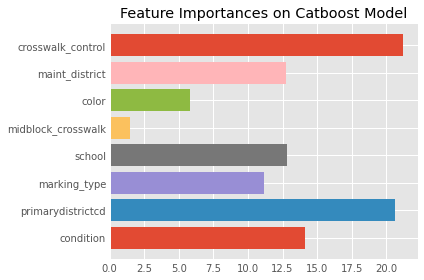

In [27]:
clf.plot_feature_importances()
# plt.savefig('../reports/crosswalks_cat_featimport.png')

#### Random Forest Blocks

In [28]:
# X = pd.get_dummies(X, drop_first=True)

In [29]:
distinct_xw.head()

,crosswalkkey,condition,primarydistrictcd,approach,marking_type,school,midblock_crosswalk,color,maint_district,crosswalk_control
0,511360,GOOD,DISTRICT3,S,LADER,0,0,WHT,CENTRAL,NONE
1,520756,GOOD,DISTRICT6,S,LADER,0,0,WHT,NORTH,SIGNAL
2,520757,GOOD,DISTRICT6,N,LADER,0,0,WHT,NORTH,SIGNAL
3,520758,GOOD,DISTRICT6,N,LADER,1,0,WHT,NORTH,NONE
4,520759,GOOD,DISTRICT6,N,LADER,1,0,WHT,NORTH,NONE


In [30]:
distinct_xw['crosswalk_control'].value_counts().index

Index(['NONE', 'SIGNAL', 'STOPSIGN', 'RFB-BCN', 'FLSH-BCN'], dtype='object')

In [31]:
cond_dict = {'GOOD':2, 'POOR':0, 'FAIR':1}
distinct_xw['condition'] = distinct_xw['condition'].map(cond_dict)

In [32]:
distinct_xw['primarydistrictcd'] = distinct_xw['primarydistrictcd'].apply(lambda x: int(x[-1]))

In [33]:
# approach_dict = {'E':1, 'N':0, 'S':2, 'W':3, 'NE':1, 'NW':0, 'SE':2, 'SW':3, 'C':4}
# distinct_xw['approach'] = distinct_xw['approach'].map(approach_dict)

In [34]:
marking_dict = {'LADER':0, 'PARSL':1, 'BRICK':2, 'CUSTOM':3, 'OTHER':4}
distinct_xw['marking_type'] = distinct_xw['marking_type'].map(marking_dict)

In [35]:
color_dict = {'WHT':0, 'RAINBOW':1, 'NONE':2, 'GRY':3, 'RED':4}
distinct_xw['color'] = distinct_xw['color'].map(color_dict)

In [36]:
maintdist_dict = {'CENTRAL':0, 'SOUTH':1, 'NORTH':2, 'SW':3}
distinct_xw['maint_district'] = distinct_xw['maint_district'].map(maintdist_dict)

In [37]:
xwcontrol_dict = {'NONE':0, 'SIGNAL':1, 'STOPSIGN':2, 'RFB-BCN':3, 'FLSH-BCN':4}
distinct_xw['crosswalk_control'] = distinct_xw['crosswalk_control'].map(xwcontrol_dict)

In [38]:
X = distinct_xw.drop(columns=['crosswalkkey', 'approach']).copy()

In [39]:
y = (y > 0).astype(int)

In [40]:
rf_kfold = RandomForestClassifier(n_estimators=400)

mses = []
accuracies = []
precisions = []
recalls = []
    
fprs = []
tprs = []
thresholds = []

feat_importances = []

kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rf_kfold.fit(X_train, y_train)
            pred = rf_kfold.predict(X_test)
            proba = rf_kfold.predict_proba(X_test)

            feat_importances.append(rf_kfold.feature_importances_)
            
            #mean squared error of the y_test values and the predicted
            err = mean_squared_error(y_test, pred)
            mses.append(err)

            #accuracy scores
            accu = accuracy_score(y_test, pred)
            accuracies.append(accu)

            #precision scores
            precise = precision_score(y_test, pred)
            precisions.append(precise)

            #recall scores
            recall = recall_score(y_test, pred)
            recalls.append(recall)
            
            roc_auc = roc_auc_score(y_test, pred)

            fpr_val, tpr_val, thresholds_val = roc_curve(y_test, proba[:, 1])

            fprs.append(fpr_val)
            tprs.append(tpr_val)
            thresholds.append(thresholds_val)

In [41]:
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
print(f'     Average MSE Score       : {np.mean(mses):2.5f}')
print(f'     ROC AUC Score           : {roc_auc:2.2f}')

     Average Accuracy Score  : 0.62186
     Average Precision Score : 0.44834
     Average Recall Score    : 0.17276
     Average MSE Score       : 0.37814
     ROC AUC Score           : 0.53


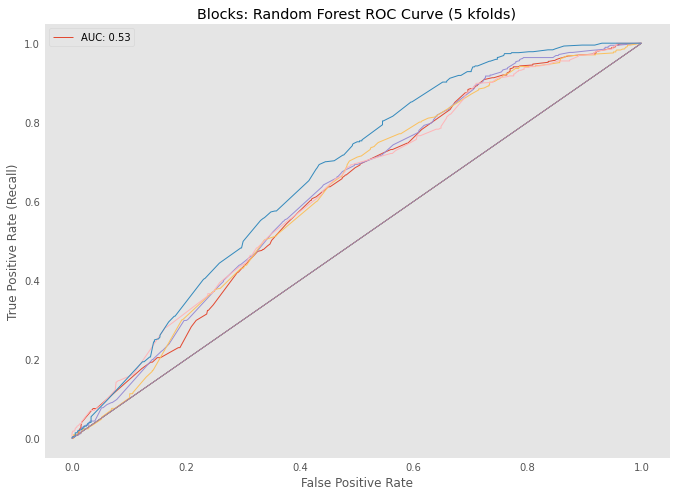

In [42]:
fig, ax = plt.subplots(figsize=(10,8))

for i in range(len(fprs)):
    ax.plot(fprs[i], tprs[i], linewidth=1)
    ax.plot([0,1], [0,1], linewidth=0.7)
    ax.grid(False)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title('Blocks: Random Forest ROC Curve (5 kfolds)')
ax.legend([f'AUC: {roc_auc:2.2f}'])
    
plt.savefig('../reports/figures/crosswalks_rf_kfolds.png')

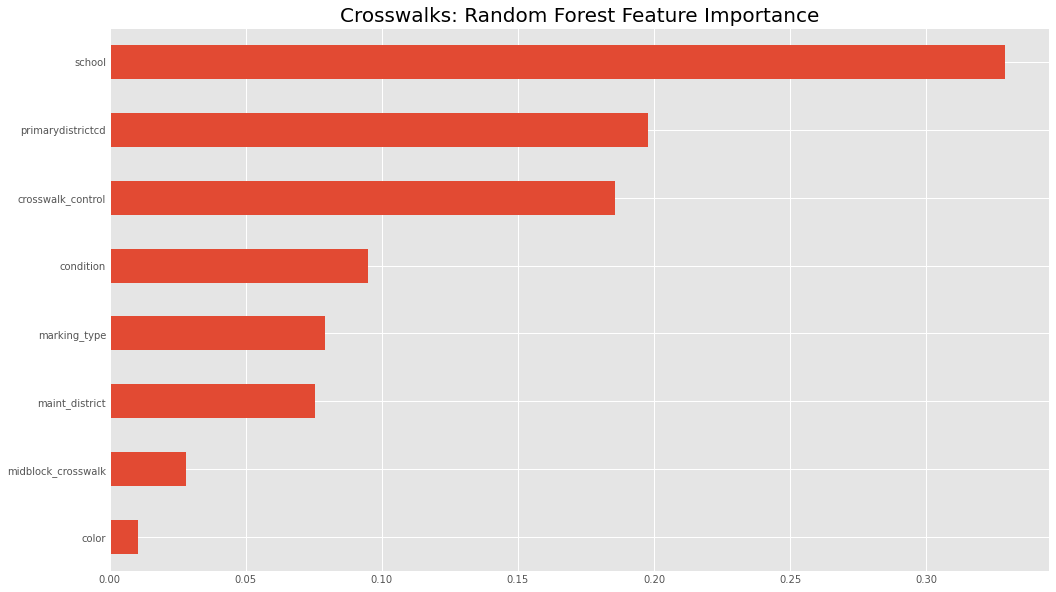

In [44]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(15,10))

feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf_kfold.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
# ax = barh(feat_scores.index, feat_scores['Fraction of Samples Affected'])
ax = feat_scores['Fraction of Samples Affected'].plot(kind='barh')
ax.set_title('Crosswalks: Random Forest Feature Importance', fontsize=20);

plt.savefig('../reports/figures/crosswalks_rf_featimportance.png')